In [ ]:
import numpy as np
import os
import glob
import torch
import nibabel as nib
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:

# Define the path to the training data folder
training_data_path = "Downloads/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Choose a patient (e.g., BraTS20_Training_001)
patient_folder = "BraTS20_Training_001"
patient_path = os.path.join(training_data_path, patient_folder)

# Load NIfTI files
flair_path = os.path.join(patient_path, f"{patient_folder}_flair.nii")
t1_path = os.path.join(patient_path, f"{patient_folder}_t1.nii")
t1ce_path = os.path.join(patient_path, f"{patient_folder}_t1ce.nii")
t2_path = os.path.join(patient_path, f"{patient_folder}_t2.nii")
seg_path = os.path.join(patient_path, f"{patient_folder}_seg.nii")

# Load NIfTI files
flair_img = nib.load(flair_path)
t1_img = nib.load(t1_path)
t1ce_img = nib.load(t1ce_path)
t2_img = nib.load(t2_path)
seg_img = nib.load(seg_path)

# Print shapes
print("FLAIR shape:", flair_img.shape)
print("T1 shape:", t1_img.shape)
print("T1 with contrast enhancement shape:", t1ce_img.shape)
print("T2 shape:", t2_img.shape)
print("Segmentation mask shape:", seg_img.shape)

FLAIR shape: (240, 240, 155)
T1 shape: (240, 240, 155)
T1 with contrast enhancement shape: (240, 240, 155)
T2 shape: (240, 240, 155)
Segmentation mask shape: (240, 240, 155)


In [ ]:
# Function to display the central slice along the Z-axis for multiple modalities
def plot_central_slices_z(patient_folder):
    # Define the path to the training data folder
    patient_path = os.path.join(training_data_path, patient_folder)

    # Load NIfTI files
    modalities = ["flair", "t1", "t1ce", "t2", "seg"]
    images = [nib.load(os.path.join(patient_path, f"{patient_folder}_{modality}.nii")).get_fdata() for modality in modalities]

    # Choose the central slice along the Z-axis
    central_slice = images[0].shape[2] // 2

    # Plot the central slice for each modality
    fig, axes = plt.subplots(1, len(modalities), figsize=(15, 5))

    for i, (modality, image) in enumerate(zip(modalities, images)):
        axes[i].imshow(image[:, :, central_slice], cmap="gray")
        axes[i].set_title(f"{modality.upper()}")

    plt.show()


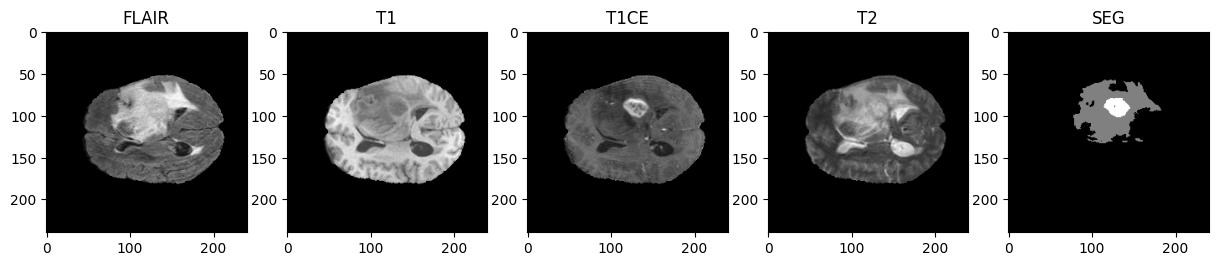

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_001"
plot_central_slices_z(patient_folder)

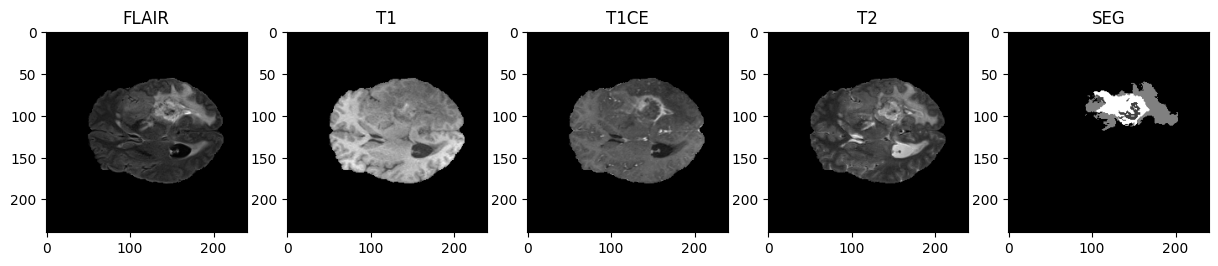

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_009"
plot_central_slices_z(patient_folder)

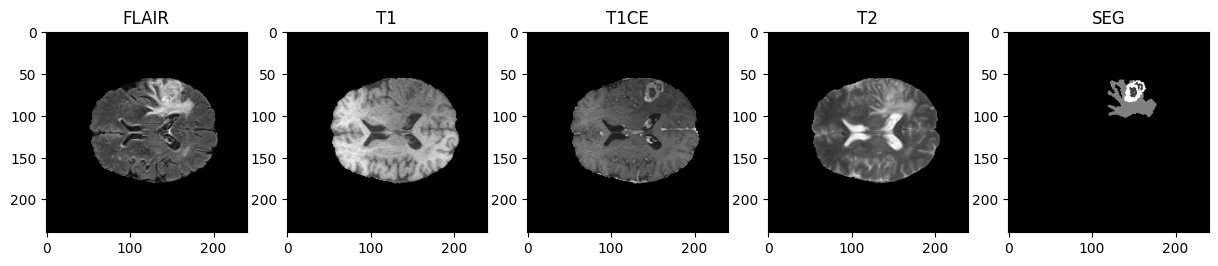

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_029"
plot_central_slices_z(patient_folder)

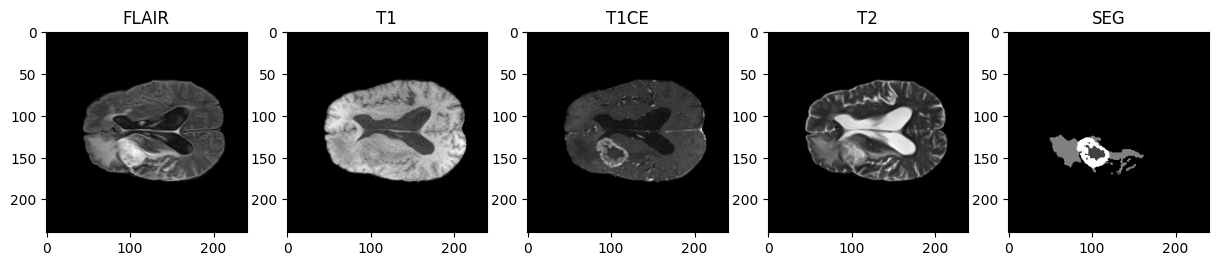

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_109"
plot_central_slices_z(patient_folder)

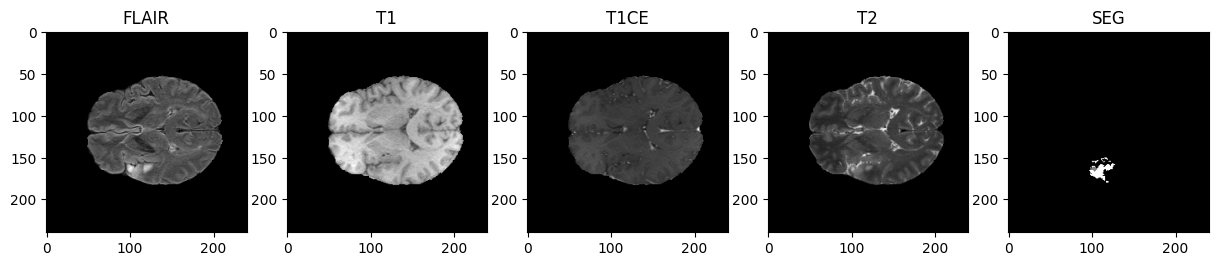

In [ ]:
# Specify the patient folder
patient_folder = "BraTS20_Training_019"
plot_central_slices_z(patient_folder)

In [ ]:
# Update the paths
t1_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t1.nii')))
t2_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(training_data_path, '*/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(training_data_path, '*/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(training_data_path, '*/*seg.nii')))

In [ ]:
def extract_slices(t1ce_list, mask_list, output_folder):
    os.makedirs(os.path.join(output_folder, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_folder, 'masks'), exist_ok=True)

    for t1ce_path, mask_path in zip(t1ce_list, mask_list):
        # Extract patient or image ID from the file path (you may need to adjust this based on your file structure)
        patient_id = os.path.basename(os.path.dirname(t1ce_path))

        # Load and preprocess the images
        t1ce_img = nib.load(t1ce_path).get_fdata()
        mask_img = nib.load(mask_path).get_fdata()
        mask_img[mask_img == 4] = 3

        # Ensure the dimensions match
        assert t1ce_img.shape == mask_img.shape, "Mismatched dimensions between T1CE and mask."

        # Iterate over slices along the z-axis
        for slice_idx in range(t1ce_img.shape[2]):
            t1ce_slice = t1ce_img[:, :, slice_idx]
            mask_slice = mask_img[:, :, slice_idx]

            # Save the slices as numpy files in separate folders with patient ID in the filename
            np.save(os.path.join(output_folder, 'images', f"t1ce_{patient_id}_{slice_idx}.npy"), t1ce_slice)
            np.save(os.path.join(output_folder, 'masks', f"mask_{patient_id}_{slice_idx}.npy"), mask_slice)

In [ ]:
output_folder = "Downloads/Train_T1CE"

# Call the function
extract_slices(t1ce_list, mask_list, output_folder)

In [ ]:
# Specify the paths to the image and mask folders
t1ce_images_folder = "Downloads/Train_T1CE/images"
masks_folder = "Downloads/Train_T1CE/masks"

# Count the number of images and masks
num_images = len(os.listdir(t1ce_images_folder))
num_masks = len(os.listdir(masks_folder))

# Print the counts
print("Number of images:", num_images)
print("Number of masks:", num_masks)

Number of images: 57195
Number of masks: 57195


In [ ]:
# Function to load and visualize images and masks
def visualize_images_masks(images_folder, masks_folder, num_samples=3):
    image_files = os.listdir(images_folder)[20:20+num_samples]

    for image_file in image_files:

        image_path = os.path.join(images_folder, image_file)
        #print(image_path)

        mask_name = image_file.replace("t1ce", "mask")
        mask_path = os.path.join(masks_folder, mask_name)
        #print(mask_path)

        # Load images and masks
        image = np.load(image_path)
        mask = np.load(mask_path)
        #print(image.shape, mask.shape)
        # Plot the images and masks side by side
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('T1CE Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='viridis')  # Assuming binary mask, adjust cmap as needed
        plt.title('Segmentation Mask')
        plt.axis('off')

        plt.show()


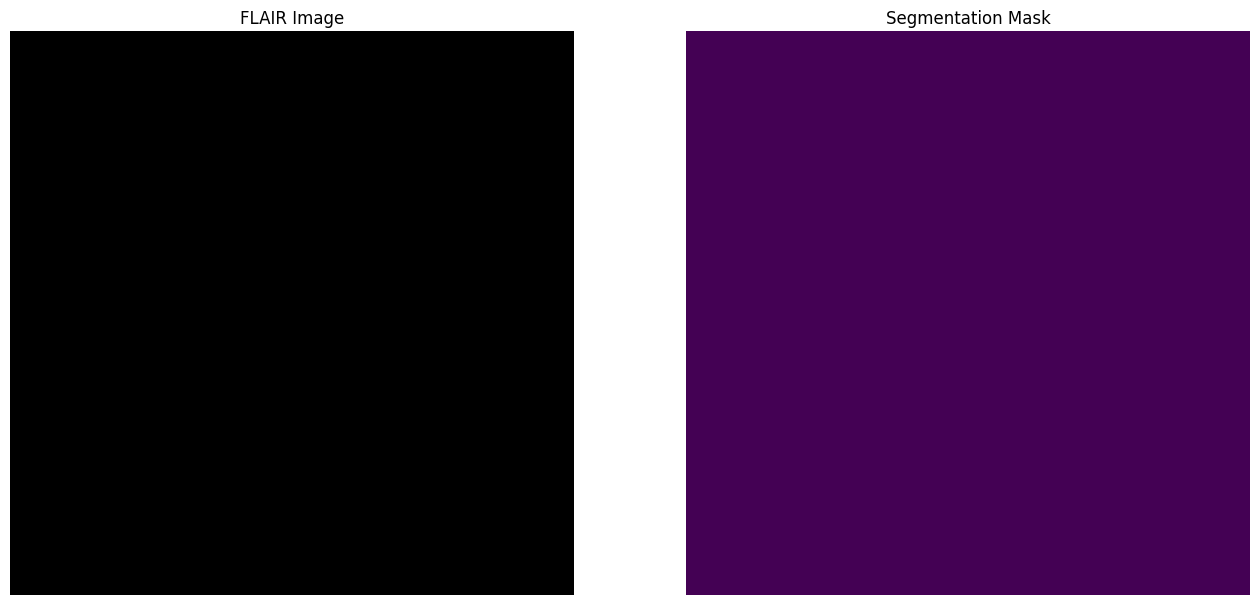

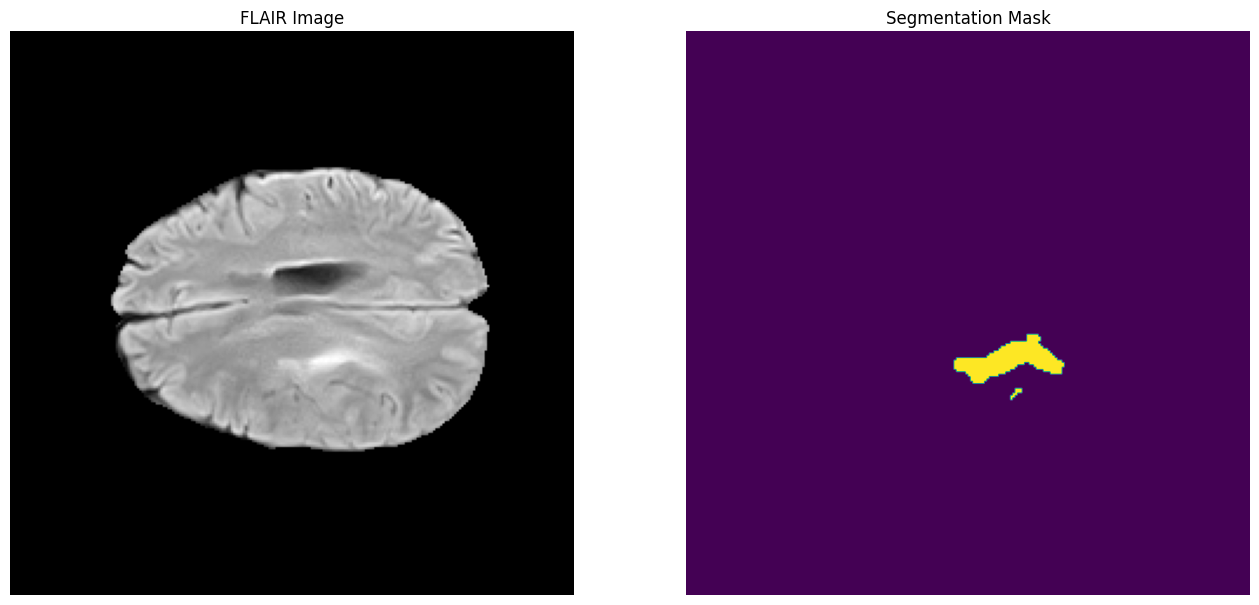

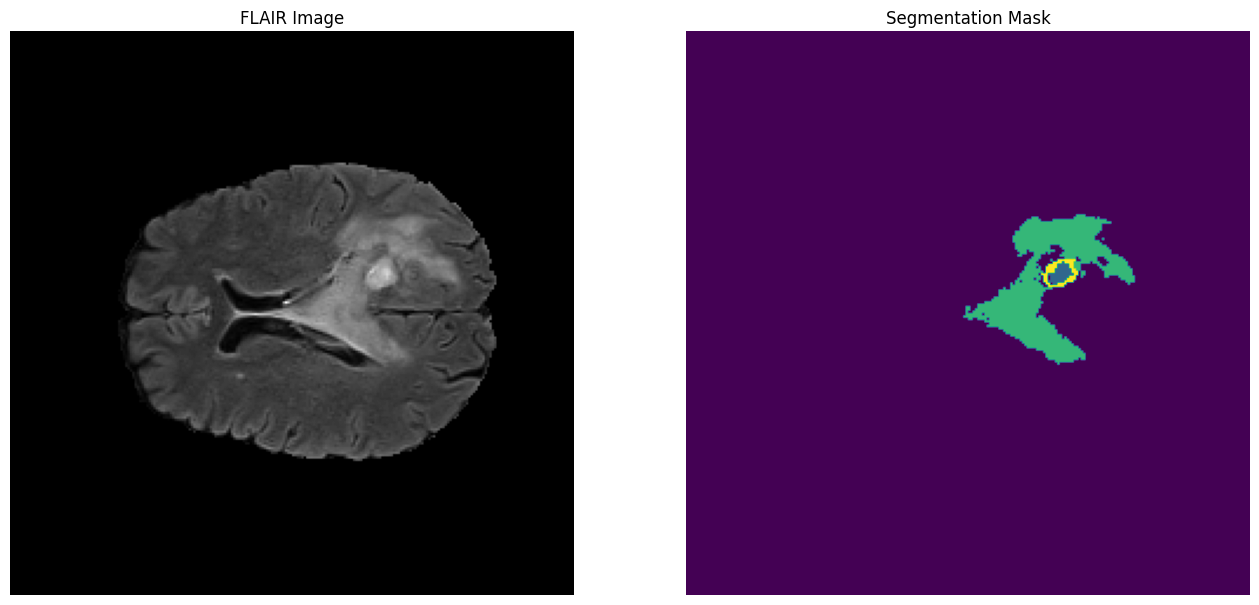

In [ ]:
# Visualize a few images and masks
visualize_images_masks(flair_images_folder, masks_folder, num_samples=3)

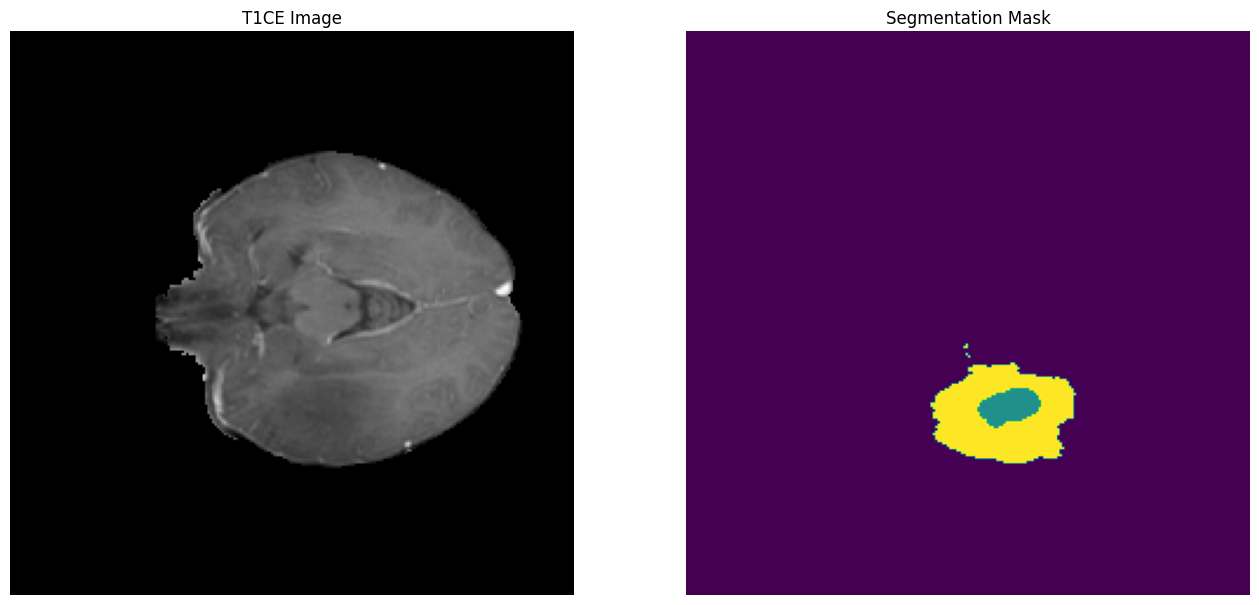

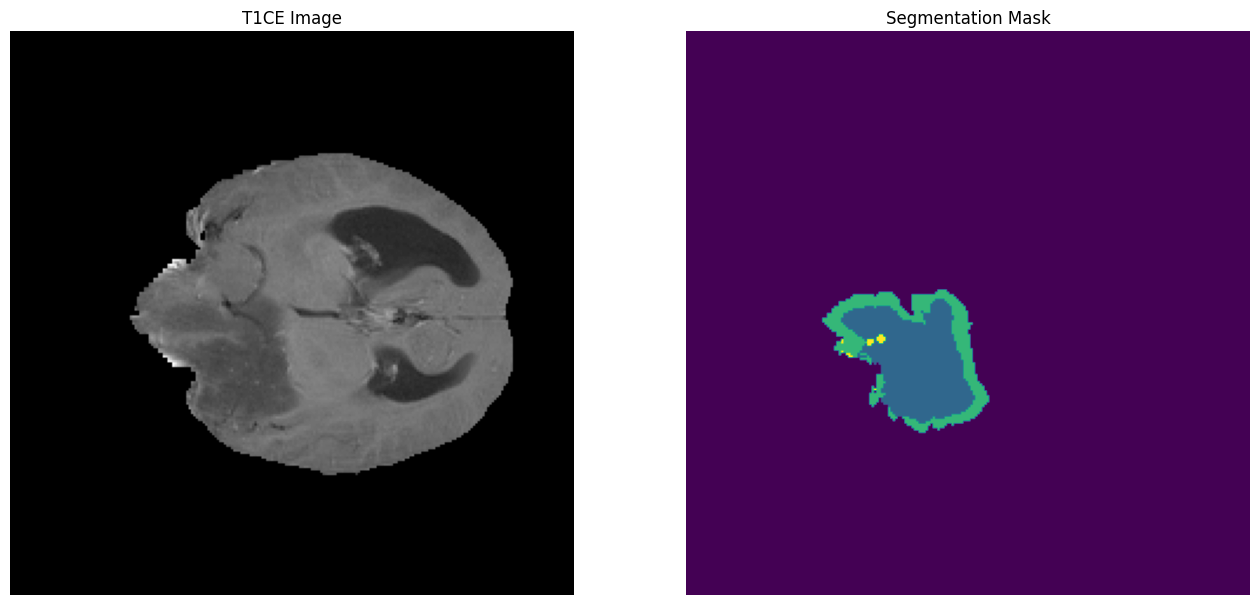

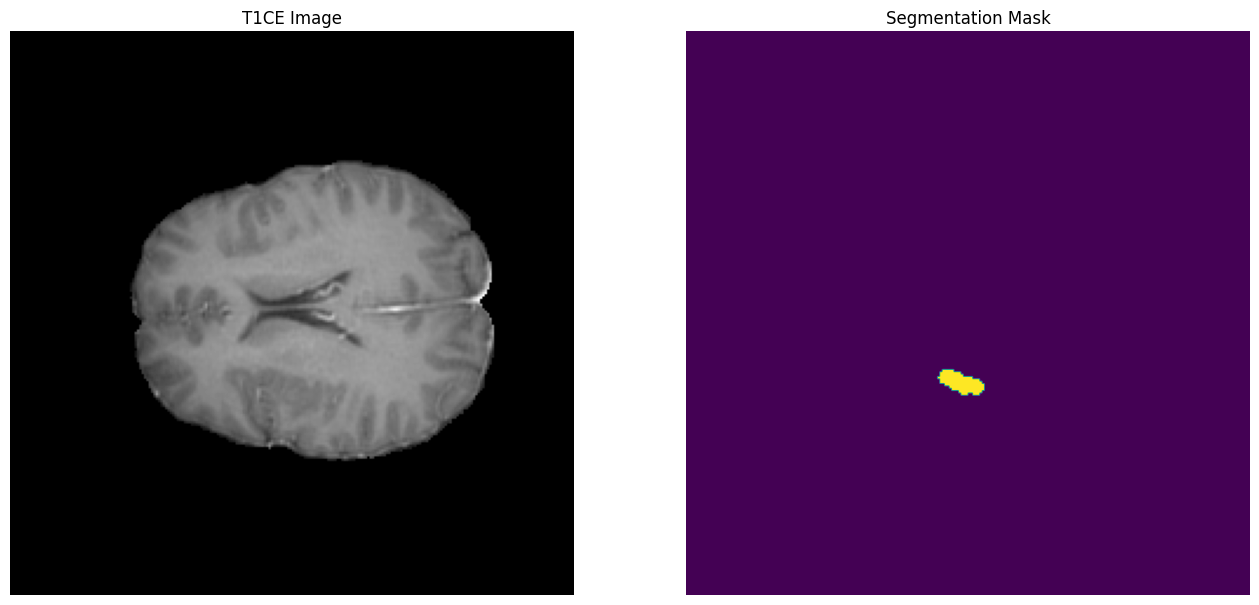

In [ ]:
visualize_images_masks(t1ce_images_folder, masks_folder, num_samples=3)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        x= self.final_conv(x)
        x= F.softmax(x, dim=1)
        #x = torch.argmax(x, dim=1, keepdim=True)
        #x = torch.nn.functional.one_hot(x.squeeze(1), 4).permute(0, 3, 1, 2)
        return x

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1e-5

        # Flatten the logits and targets
        logits_flat = logits.view(-1)
        targets_flat = targets.view(-1)

        intersection = (logits_flat * targets_flat).sum()
        union = logits_flat.sum() + targets_flat.sum()

        dice_coefficient = (2. * intersection + smooth) / (union + smooth)

        dice_loss = 1 - dice_coefficient

        return dice_loss

In [ ]:
import torch

# Create dummy input and target
logits = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])  # Example logits (replace with your own)
targets = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])  # Example targets (replace with your own)

# Instantiate DiceLoss
dice_loss = DiceLoss()

# Forward pass
loss = dice_loss(logits, targets)

print(f"Dice Loss for perfect overlap: {loss.item()}")

Dice Loss for perfect overlap: 0.0


In [ ]:
# Create dummy input and target with no overlap
logits_no_overlap = torch.tensor([[[[0.0, 0.0], [0.0, 0.0]]]])
targets_no_overlap = torch.tensor([[[[1.0, 1.0], [1.0, 1.0]]]])

# Forward pass
loss_no_overlap = dice_loss(logits_no_overlap, targets_no_overlap)

print(f"Dice Loss for no overlap: {loss_no_overlap.item()}")

Dice Loss for no overlap: 0.9999974966049194


In [ ]:
# Create dummy one-hot encoded ground truth and predicted values
ground_truth = torch.tensor([[[[0, 1], [1, 0]]]])  # Example one-hot encoded ground truth
predicted_values = torch.tensor([[[[0.2, 0.8], [0.6, 0.4]]]])  # Example predicted values (after softmax)

# Forward pass
loss_segmentation = dice_loss(predicted_values, ground_truth)

print(f"Dice Loss for segmentation example: {loss_segmentation.item()}")


Dice Loss for segmentation example: 0.2999991774559021


In [ ]:
model = UNET(in_channels=1, out_channels=4)
model.eval()
x = torch.randn((2, 1, 240, 240))
save=x

In [ ]:
with torch.no_grad():
    y = model(x)
print(x.shape,y.shape,y[0,0,0,0],y[0,1,0,0],y[0,2,0,0],y[0,3,0,0])
#print(y)
#abc = torch.argmax(y, dim=1, keepdim=True)
#print(abc.shape)
#print(abc)


torch.Size([2, 1, 240, 240]) torch.Size([2, 4, 240, 240]) tensor(0.2616) tensor(0.2616) tensor(0.2411) tensor(0.2357)


In [ ]:
with torch.no_grad():
    y = model(save)

print(save.shape,y.shape,y[0,0,0,0],y[0,1,0,0],y[0,2,0,0],y[0,3,0,0])
#abc = torch.argmax(y, dim=1, keepdim=True)
#print(abc.shape,abc[0,0])


torch.Size([2, 1, 240, 240]) torch.Size([2, 4, 240, 240]) tensor(0.2616) tensor(0.2616) tensor(0.2411) tensor(0.2357)


In [ ]:
# Apply one-hot encoding to the predicted class indices
#abc_hot = torch.nn.functional.one_hot(abc.squeeze(1), num_classes=4).permute(0, 3, 1, 2)
#print(abc_hot.shape)

torch.Size([2, 4, 240, 240])


In [ ]:
model.load_state_dict(torch.load("unet_flair_144_2.pth"))

# Make sure to set the model to evaluation mode if needed
model.eval()


UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
# Check a few values in abc_hot
print("abc_hot[0, 0, 0, 0]:", abc_hot[0, 0, 0, 1])
print("abc_hot[0, 1, 0, 0]:", abc_hot[0, 1, 0, 1])
print("abc_hot[1, 0, 1, 1]:", abc_hot[0, 2, 0, 1])
print("abc_hot[1, 2, 2, 2]:", abc_hot[0, 3, 0, 1])


NameError: ignored

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_folder, masks_folder, transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.transform = transform

        self.image_files = sorted(os.listdir(images_folder))
        self.mask_files = sorted(os.listdir(masks_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = np.load(image_path)
        mask = np.load(mask_path)

        # Apply transformations if provided
        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


In [ ]:
class ToTensor(object):
    def __call__(self, image, mask):
        # Convert to PyTorch tensors
        image = transforms.ToTensor()(image)

        # Center crop to size 128x128
        center_crop = transforms.CenterCrop((144, 144))
        image = center_crop(image)

        # Min-max normalization
        min_val = image.min()
        max_val = image.max()
        epsilon = 1e-6
        normalised_image = (image - min_val) / max((max_val - min_val), epsilon)

        # Convert segmentation mask to one-hot encoding

        num_classes = 4  # Background + 3 classes
        mask_index = torch.from_numpy(mask).long()  # Convert to a long tensor
        mask_index = center_crop(mask_index)  # Apply center crop to the mask
        mask_one_hot = torch.nn.functional.one_hot(mask_index, num_classes).permute(2, 0, 1)

        return normalised_image, mask_one_hot

In [ ]:
# Create an instance of the dataset and dataloader
dataset = CustomDataset(images_folder=t1ce_images_folder, masks_folder=masks_folder, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


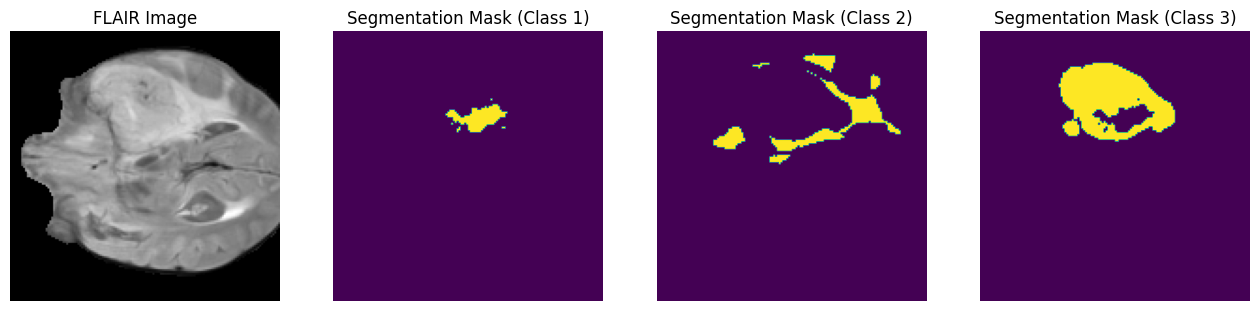

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break

Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


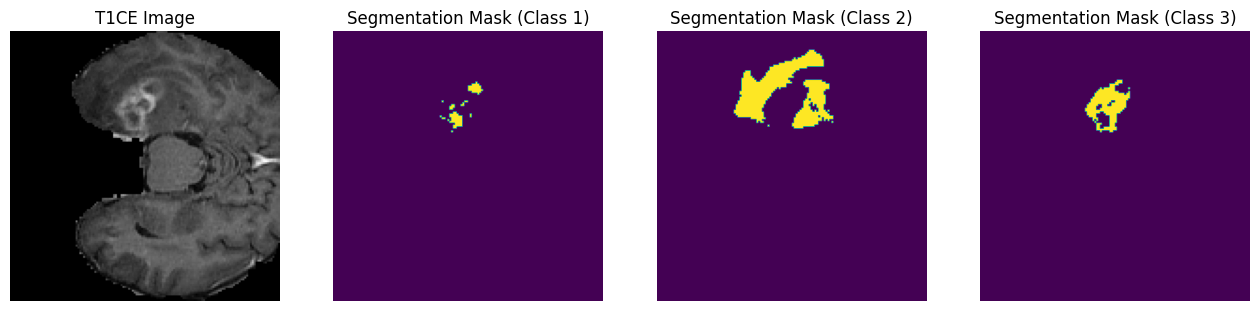

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images[0, 0], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break

Batch 1:
  Images:
    Shape: torch.Size([16, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([16, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([16, 4, 144, 144])
Argmax Shape torch.Size([16, 1, 144, 144])
tensor([[[[2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 0,  ..., 0, 2, 2],
          [2, 2, 0,  ..., 0, 0, 2],
          ...,
          [2, 2, 0,  ..., 0, 0, 2],
          [2, 2, 2,  ..., 0, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]],


        [[[2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 0,  ..., 0, 2, 2],
          [2, 2, 0,  ..., 0, 0, 2],
          ...,
          [2, 2, 0,  ..., 0, 0, 2],
          [2, 2, 2,  ..., 0, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]],


        [[[2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 0,  ..., 0, 2, 2],
          [2, 2, 0,  ..., 0, 0, 2],
          ...,
          [2, 2, 0,  ..., 0, 0, 2],
          [2, 2, 2,  ..., 0, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]],


       

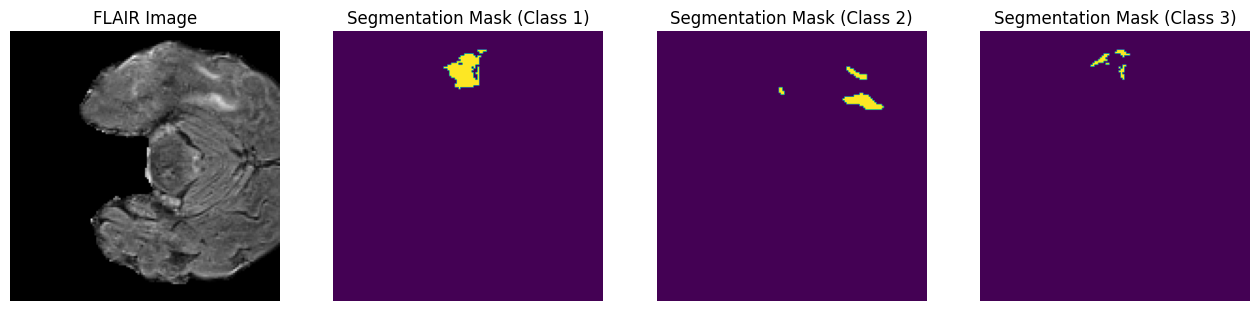

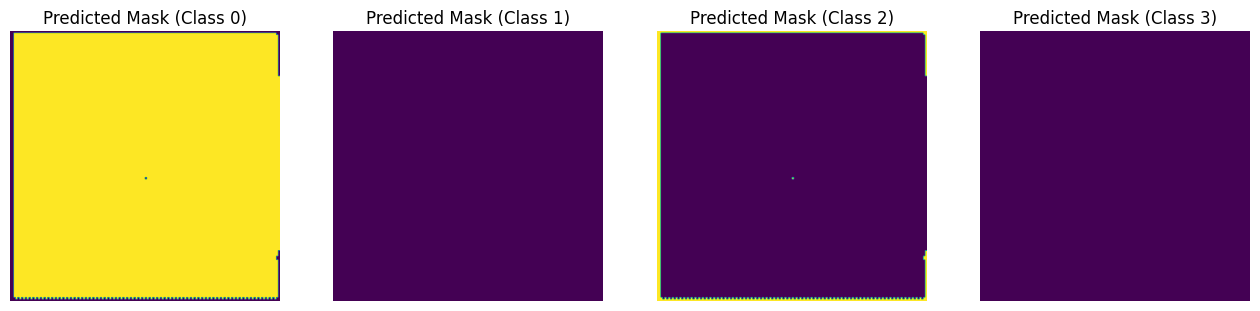

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      print(preds)

      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      print(preds[0,0])
      print(preds[0,1])
      print(preds[0,2])
      print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


In [ ]:
dice_loss = DiceLoss()
# Define optimizer, device, etc. (as in the previous example)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
#device = torch.device("cpu")
model = model.to(device)

In [ ]:
dice_loss = DiceLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device
#device = torch.device("cpu")
model = model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    # Use tqdm for progress bar
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, masks) in pbar:
        # Move data to the device
        images, masks = images.to(device), masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        images = images.float()

        # Forward pass
        outputs = model(images)
        #outputs = torch.argmax(outputs, dim=1, keepdim=True)
        #outputs = torch.nn.functional.one_hot(outputs.squeeze(1), 4).permute(0, 3, 1, 2)
        #outputs.requires_grad = True  # Ensure that gradients are computed for this tensor

        # Calculate the Dice Loss
        loss = dice_loss(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for printing
        total_loss += loss.item()

        # Update tqdm progress bar
        pbar.set_postfix({"Dice Loss": loss.item()})

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Dice Loss: {average_loss:.4f}")

# Optionally, save the trained model
torch.save(model.state_dict(), "unet_t1ce_144_0.pth")

Epoch 1/20: 100%|███████████| 894/894 [23:04<00:00,  1.55s/it, Dice Loss=0.0326]


Epoch [1/20], Average Dice Loss: 0.0257


Epoch 2/20: 100%|███████████| 894/894 [23:59<00:00,  1.61s/it, Dice Loss=0.0182]


Epoch [2/20], Average Dice Loss: 0.0216


Epoch 3/20: 100%|███████████| 894/894 [22:25<00:00,  1.50s/it, Dice Loss=0.0182]


Epoch [3/20], Average Dice Loss: 0.0202


Epoch 4/20: 100%|███████████| 894/894 [22:15<00:00,  1.49s/it, Dice Loss=0.0118]


Epoch [4/20], Average Dice Loss: 0.0193


Epoch 5/20: 100%|███████████| 894/894 [23:23<00:00,  1.57s/it, Dice Loss=0.0116]


Epoch [5/20], Average Dice Loss: 0.0188


Epoch 6/20: 100%|███████████| 894/894 [22:15<00:00,  1.49s/it, Dice Loss=0.0199]


Epoch [6/20], Average Dice Loss: 0.0184


Epoch 7/20: 100%|███████████| 894/894 [22:12<00:00,  1.49s/it, Dice Loss=0.0256]


Epoch [7/20], Average Dice Loss: 0.0181


Epoch 8/20: 100%|███████████| 894/894 [22:28<00:00,  1.51s/it, Dice Loss=0.0166]


Epoch [8/20], Average Dice Loss: 0.0178


Epoch 9/20: 100%|███████████| 894/894 [22:24<00:00,  1.50s/it, Dice Loss=0.0295]


Epoch [9/20], Average Dice Loss: 0.0176


Epoch 10/20: 100%|██████████| 894/894 [22:24<00:00,  1.50s/it, Dice Loss=0.0141]


Epoch [10/20], Average Dice Loss: 0.0172


Epoch 11/20: 100%|██████████| 894/894 [22:44<00:00,  1.53s/it, Dice Loss=0.0108]


Epoch [11/20], Average Dice Loss: 0.0131


Epoch 12/20: 100%|██████████| 894/894 [22:14<00:00,  1.49s/it, Dice Loss=0.0119]


Epoch [12/20], Average Dice Loss: 0.0119


Epoch 13/20: 100%|██████████| 894/894 [22:25<00:00,  1.50s/it, Dice Loss=0.0125]


Epoch [13/20], Average Dice Loss: 0.0114


Epoch 14/20: 100%|██████████| 894/894 [22:22<00:00,  1.50s/it, Dice Loss=0.0129]


Epoch [14/20], Average Dice Loss: 0.0111


Epoch 15/20: 100%|██████████| 894/894 [22:18<00:00,  1.50s/it, Dice Loss=0.0133]


Epoch [15/20], Average Dice Loss: 0.0109


Epoch 16/20: 100%|█████████| 894/894 [22:21<00:00,  1.50s/it, Dice Loss=0.00767]


Epoch [16/20], Average Dice Loss: 0.0107


Epoch 17/20: 100%|███████████| 894/894 [22:17<00:00,  1.50s/it, Dice Loss=0.012]


Epoch [17/20], Average Dice Loss: 0.0106


Epoch 18/20: 100%|██████████| 894/894 [22:56<00:00,  1.54s/it, Dice Loss=0.0104]


Epoch [18/20], Average Dice Loss: 0.0105


Epoch 19/20: 100%|██████████| 894/894 [25:56<00:00,  1.74s/it, Dice Loss=0.0134]


Epoch [19/20], Average Dice Loss: 0.0104


Epoch 20/20: 100%|██████████| 894/894 [22:12<00:00,  1.49s/it, Dice Loss=0.0103]


Epoch [20/20], Average Dice Loss: 0.0102


In [ ]:
# Optionally, save the trained model
torch.save(model.state_dict(), "unet_model_144_1.pth")

After 1 epoch

Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


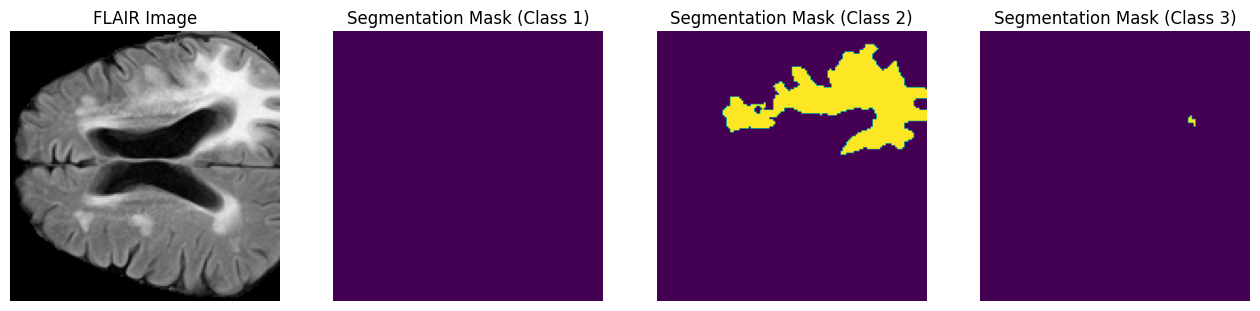

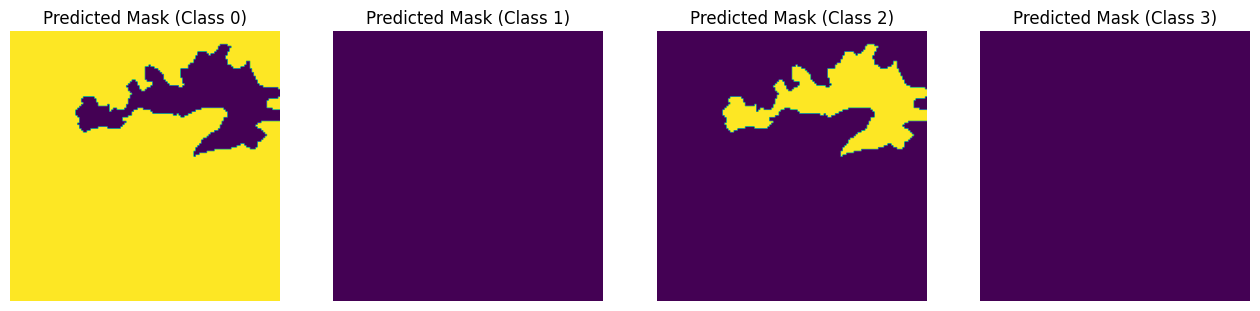

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


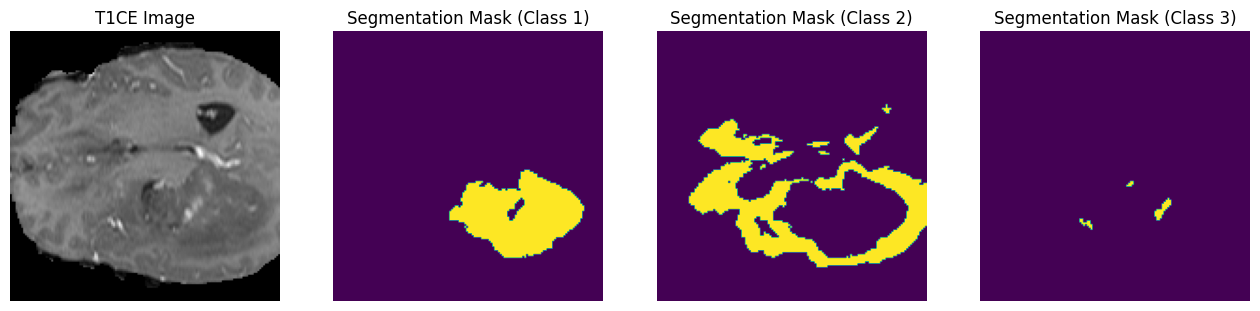

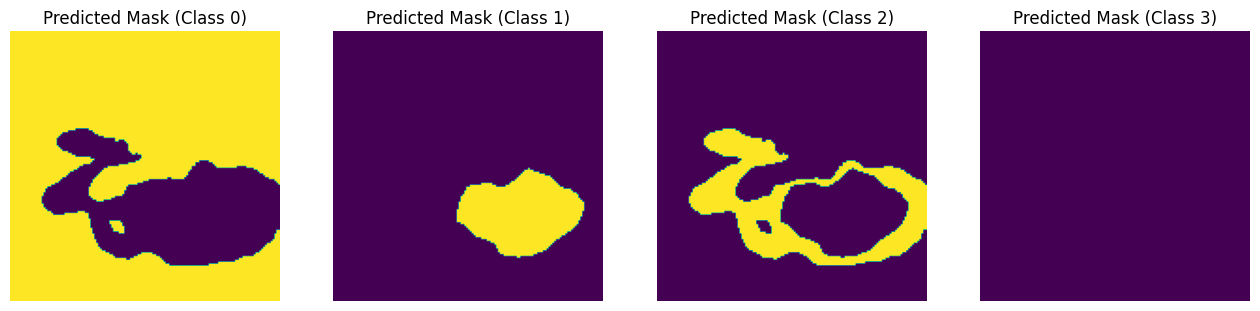

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


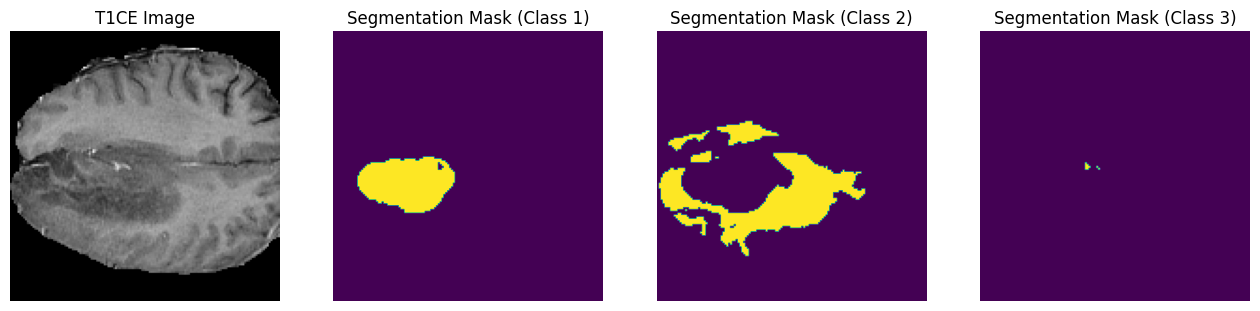

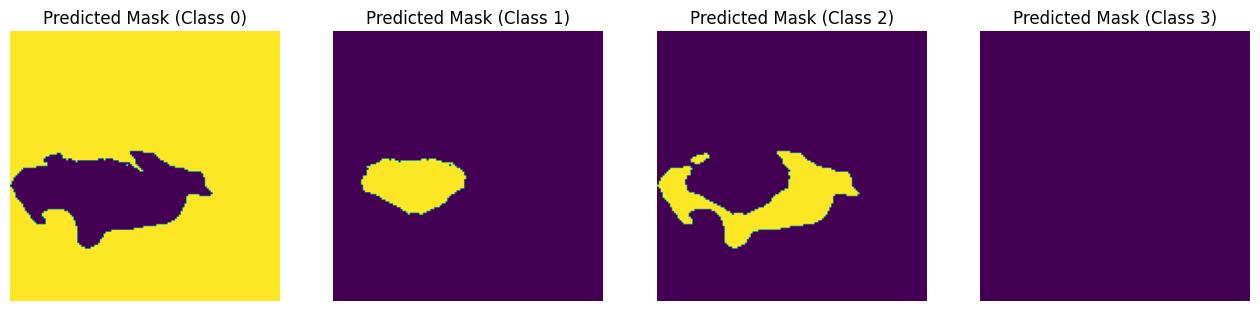

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


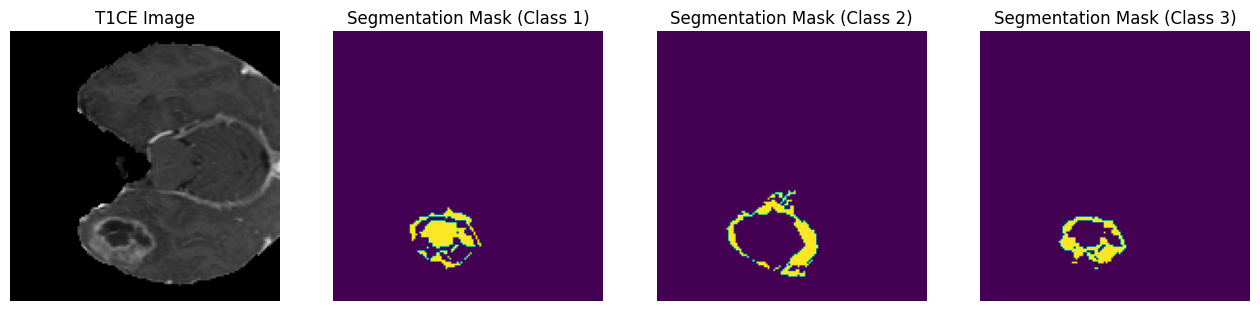

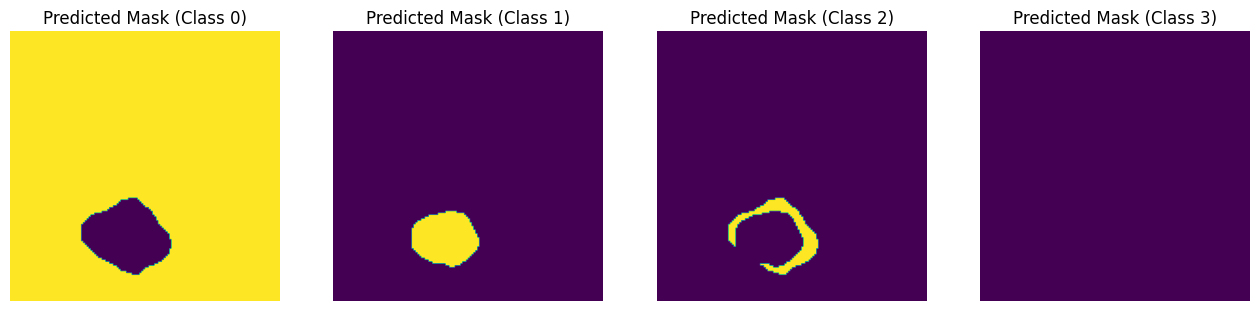

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


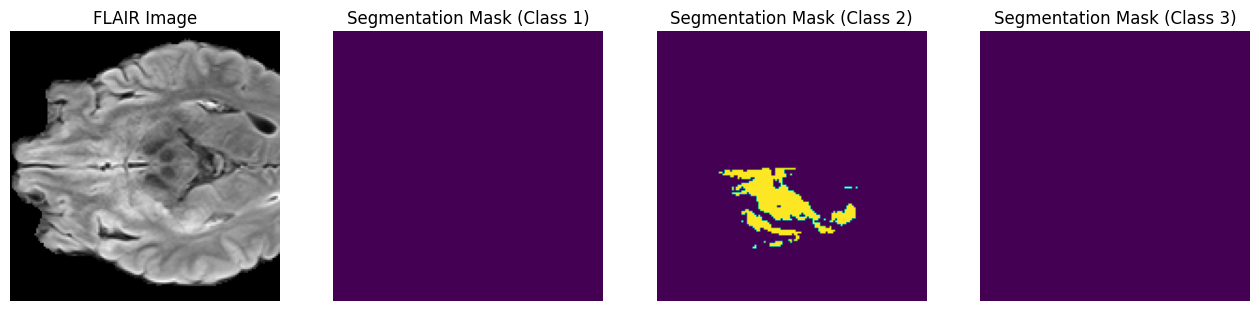

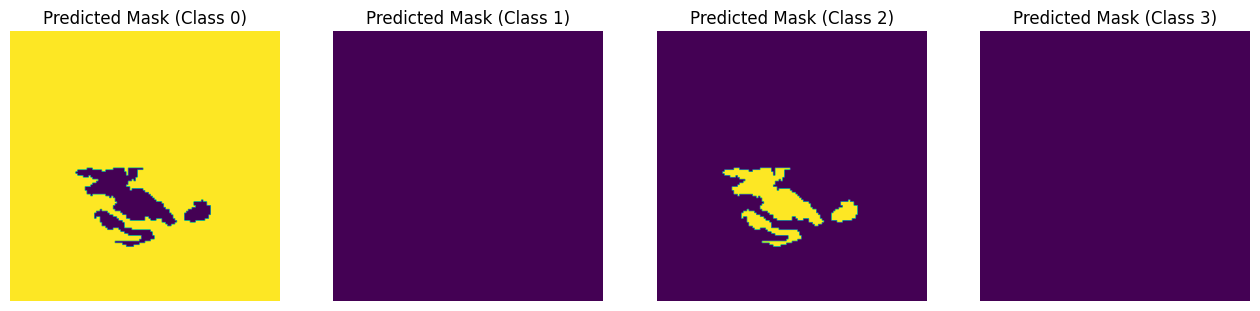

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


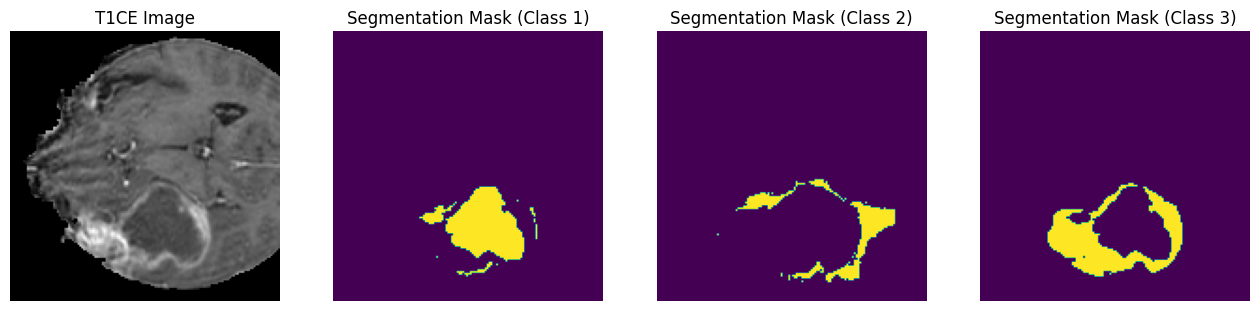

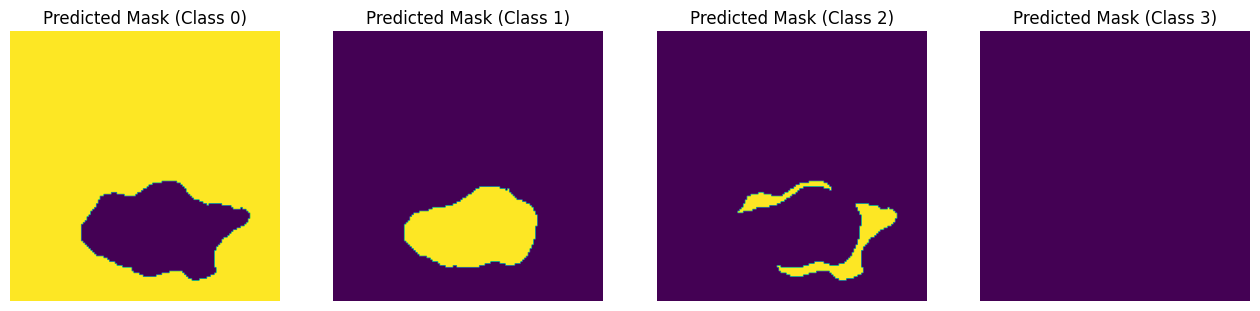

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('T1CE Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


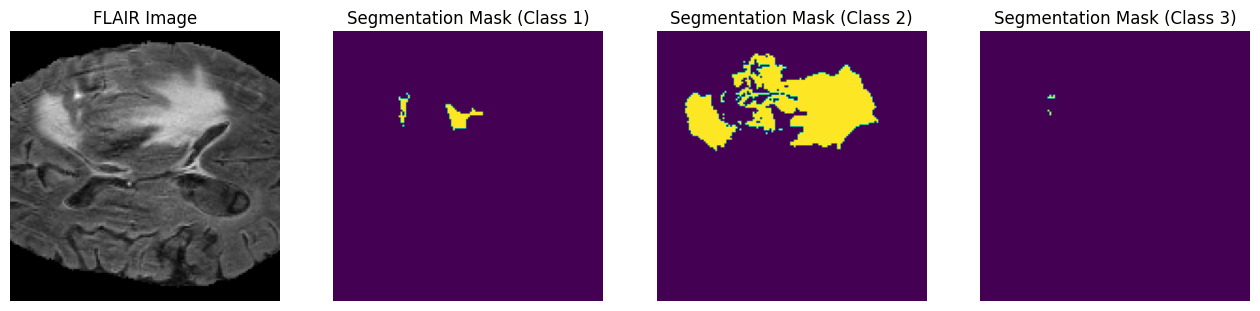

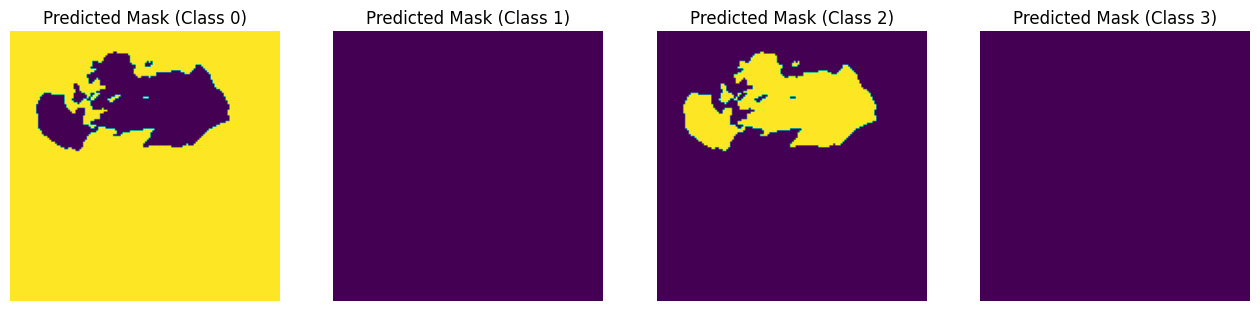

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


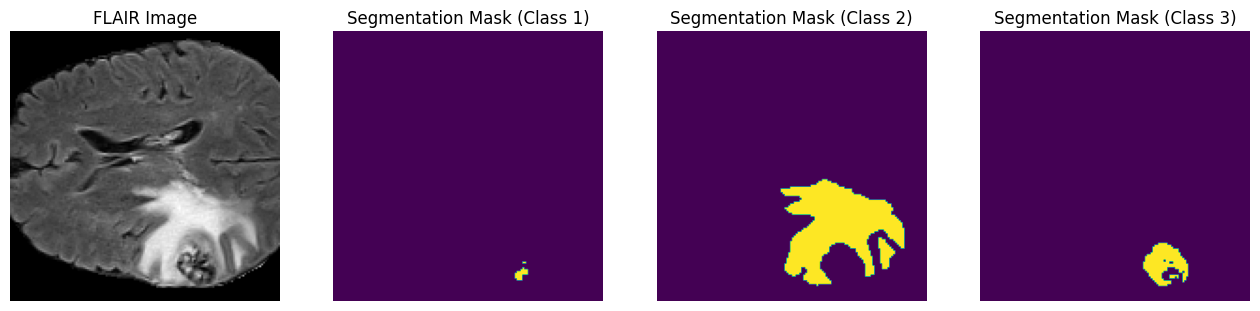

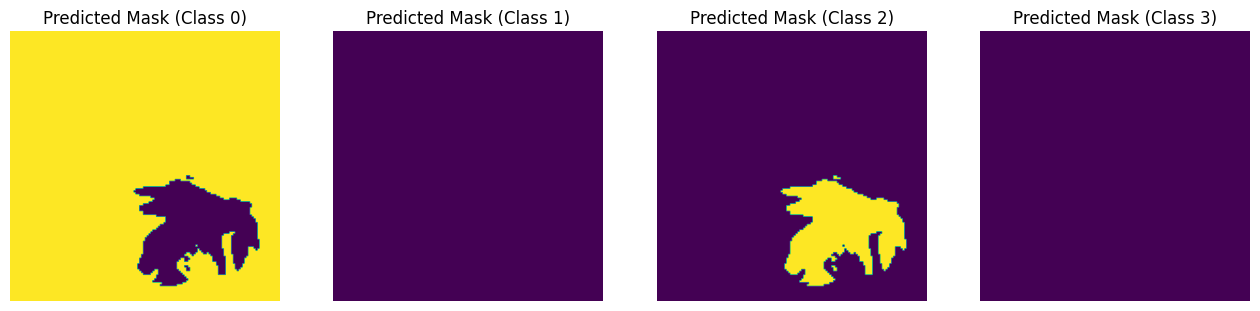

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([64, 1, 144, 144])
    Type: torch.float64
    Type after Float: torch.float32
  Masks:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64
Model Prediction Shape torch.Size([64, 4, 144, 144])
Argmax Shape torch.Size([64, 1, 144, 144])
One Hot Shape torch.Size([64, 4, 144, 144])
abc_hot[0, 0, 0, 0]: tensor(1, device='cuda:0')
abc_hot[0, 1, 0, 0]: tensor(0, device='cuda:0')
abc_hot[1, 0, 1, 1]: tensor(0, device='cuda:0')
abc_hot[1, 2, 2, 2]: tensor(0, device='cuda:0')
  Preds:
    Shape: torch.Size([64, 4, 144, 144])
    Type: torch.int64


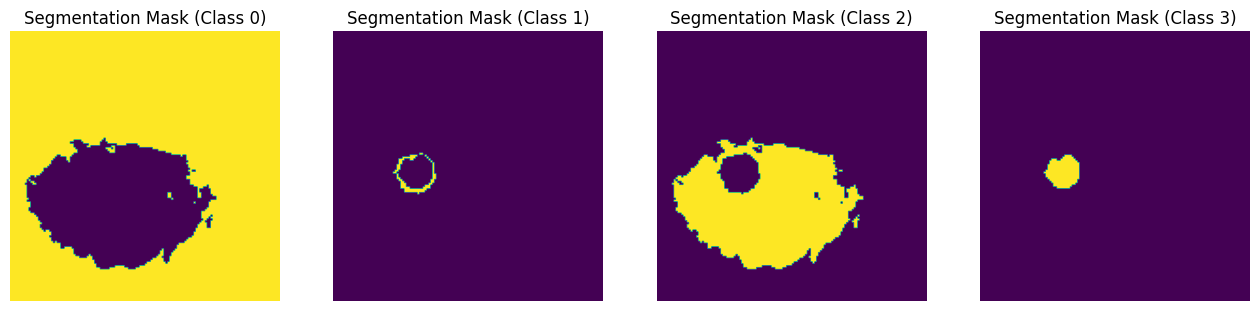

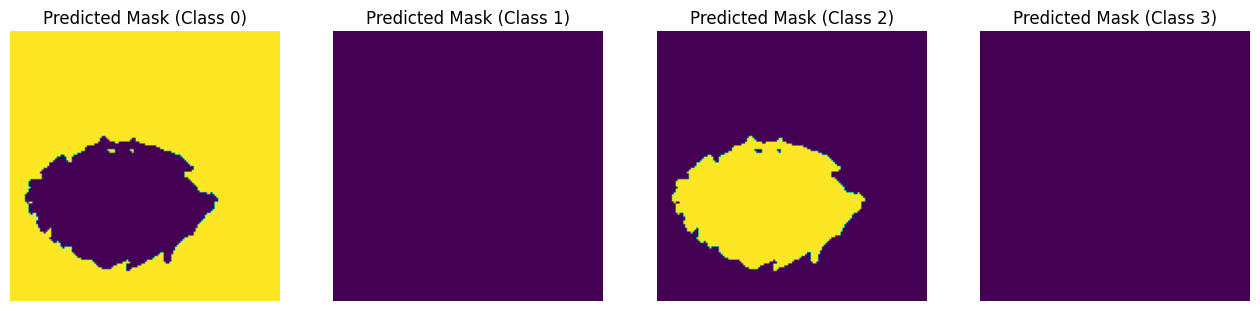

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")

    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.to(device)
    images = images.float()
    print(f"    Type after Float: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)
      print("Model Prediction Shape",preds.shape)
      # Apply one-hot encoding to the predicted class indices
      preds = torch.argmax(preds, dim=1, keepdim=True)
      print("Argmax Shape",preds.shape)
      #print(preds)
      preds = torch.nn.functional.one_hot(preds.squeeze(1), 4).permute(0, 3, 1, 2)
      print("One Hot Shape",preds.shape)

      #print(preds[0,0])
      #print(preds[0,1])
      #print(preds[0,2])
      #print(preds[0,3])

      # Check a few values in abc_hot
      print("abc_hot[0, 0, 0, 0]:", preds[0, 0, 1, 1])
      print("abc_hot[0, 1, 0, 0]:", preds[0, 1, 1, 1])
      print("abc_hot[1, 0, 1, 1]:", preds[0, 2, 1, 1])
      print("abc_hot[1, 2, 2, 2]:", preds[0, 3, 1, 1])

    print(f"  Preds:")
    print(f"    Shape: {preds.shape}")
    print(f"    Type: {preds.dtype}")
    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    #plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.imshow(masks[0, 0], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 0)')
    #plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([16, 1, 240, 240])
    Type: torch.float64
    Type: torch.float32
  Masks:
    Shape: torch.Size([16, 4, 240, 240])
    Type: torch.int64


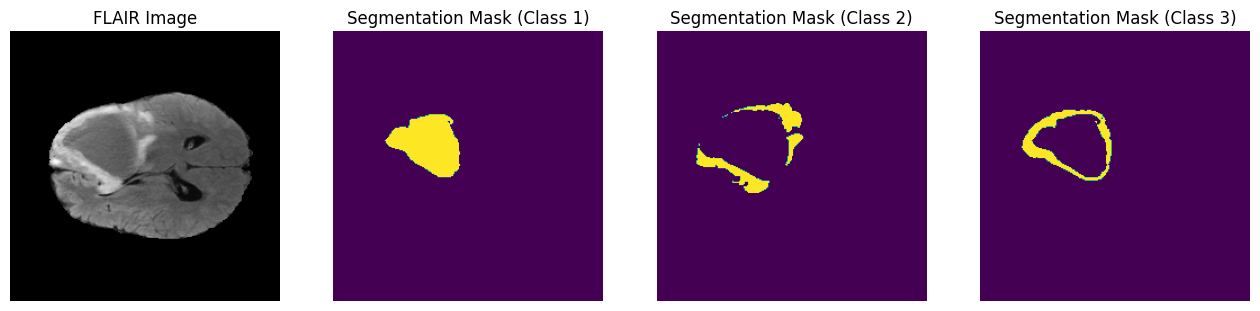

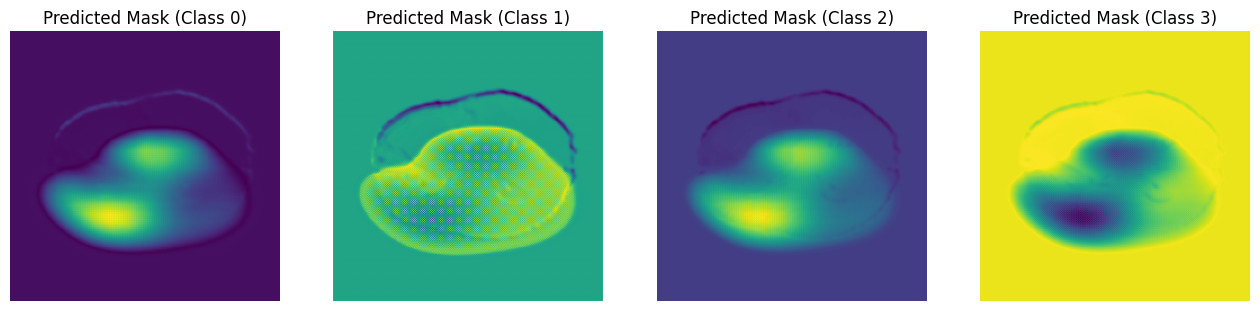

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")
    images = images.to(device)
    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.float()
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break


Batch 1:
  Images:
    Shape: torch.Size([16, 1, 240, 240])
    Type: torch.float64
    Type: torch.float32
  Masks:
    Shape: torch.Size([16, 4, 240, 240])
    Type: torch.int64


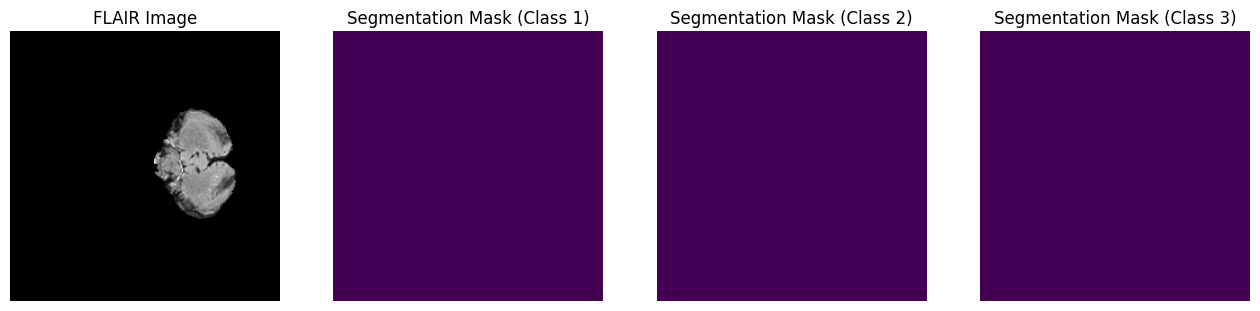

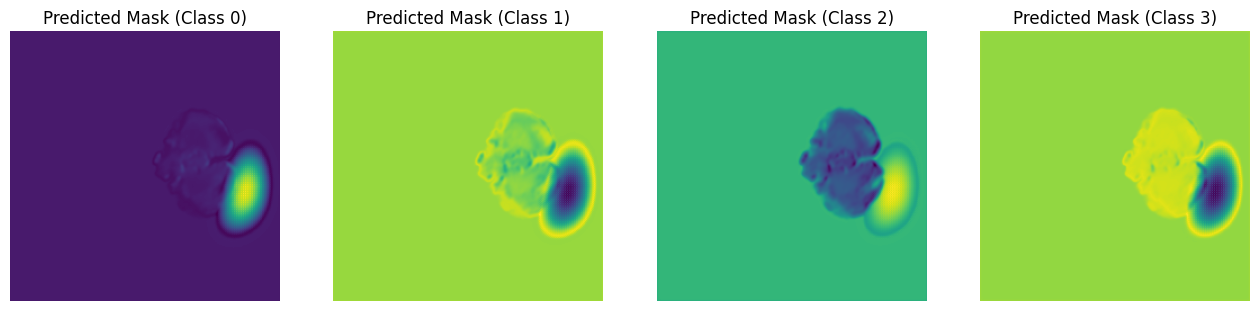

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    # Print batch information
    print(f"Batch {batch_idx + 1}:")
    images = images.to(device)
    # Print information about images
    print(f"  Images:")
    print(f"    Shape: {images.shape}")
    print(f"    Type: {images.dtype}")
    images = images.float()
    print(f"    Type: {images.dtype}")

    # Print information about masks
    print(f"  Masks:")
    print(f"    Shape: {masks.shape}")
    print(f"    Type: {masks.dtype}")
    model.eval()
    with torch.no_grad():
      # Forward pass
      preds = model(images)

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    # Plot the first image
    plt.subplot(1, 4, 1)
    plt.imshow(images.cpu()[0, 0], cmap='gray')
    plt.title('FLAIR Image')
    plt.axis('off')

    # Plot the first mask channel
    plt.subplot(1, 4, 2)
    plt.imshow(masks[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 1)')
    plt.axis('off')

    # Plot the second mask channel
    plt.subplot(1, 4, 3)
    plt.imshow(masks[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Segmentation Mask (Class 2)')
    plt.axis('off')

    # Plot the third mask channel
    plt.subplot(1, 4, 4)
    plt.imshow(masks[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Segmentation Mask (Class 3)')
    plt.axis('off')

    plt.show()

    # Visualize the first image and mask in the batch
    plt.figure(figsize=(16, 8))

    #Prediction
    plt.subplot(1, 4, 1)
    plt.imshow(preds.cpu()[0, 0], cmap='viridis')
    plt.title('Predicted Mask (Class 0)')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(preds.cpu()[0, 1], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 1)')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(preds.cpu()[0, 2], cmap='viridis')  # Displaying the mask for class 2
    plt.title('Predicted Mask (Class 2)')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(preds.cpu()[0,3], cmap='viridis')  # Displaying the mask for class 1
    plt.title('Predicted Mask (Class 3)')
    plt.axis('off')

    plt.show()
    # Stop after inspecting the first batch (remove the break statement if you want to inspect all batches)
    break
